## Example

### 1. Import the necessary packages

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from Planner.frenet_trajectory_mcity import VehicleController, FrenetPathPlanner, generate_target_course, calculate_frenet_coordinates

### 2. Simulation Environment Preparation

#### 2.1. Read the Path Varaibles

In [8]:
# Read in the Raw Map Data
path_raw = pd.read_csv('initial_information/route.csv')
path_np = path_raw.to_numpy()
path_np[0,0]= 124.7523096154207
path_np[0,1]= 15.917477574911015
wx_r = path_np[:,0]
wy_r = path_np[:,1]
path_np_10 = path_np[::100]
wx = path_np_10[:,0]
wy = path_np_10[:,1]

# Generate Reference Course
tx, ty, tyaw, tc, csp = generate_target_course(wx, wy)

#### 2.2. Define the Simulation Parameters

In [9]:
# Define the window Area
area = 70.0 
SIM_LOOP = 500
show_animation = True

### 3. Define the Vehicle and the Planner

#### 3.1. Define the Vehicle and the Planner

In [10]:
# Define the Driving Vehicle 
vehicle_drive = VehicleController(1.2, 5, 0, 0, np.pi/4)

# Set the Initial State of the Vehicle
c_speed = 0  # current speed [m/s]
c_accel = 0.0  # current acceleration [m/s^2]
c_d = 0.0  # current lateral position [m]
c_d_d = 0.0  # current lateral speed [m/s]
c_d_dd = 0.0  # current lateral acceleration [m/s^2]
s0 = 0.0  # current course position

# Define the Planner
Planner = FrenetPathPlanner(vehicle_drive)
Planner.set_initial_variables(
        c_speed,
        c_accel,
        c_d,
        c_d_d,
        c_d_dd,
        s0)

#### 3.2. Define the Traffic Light and Obsticles

In [11]:
# Define obstacle lists
obstacle1 = VehicleController(1.2, 5, wx_r[700], wy_r[700], np.pi/2)
obstacle2 = VehicleController(1.2, 5, 50, 10, np.pi/4)
diff_vehicles = 0  # Difference between the leading vehicle and the following vehicle
lead_vehicle_exist = False  # Check if the leading vehicle exist
stop_exist = False  # Check if the stopping condition Exist

# Define Traffic Light Location
traffic_light_x = wx_r[500]
traffic_light_y = wy_r[500]
traffic_light_s, _ = calculate_frenet_coordinates(wx, wy, traffic_light_x, traffic_light_y)
stop_distance = 0
lead_v = 0
diff_vehicles = 0

### 4. Simulation

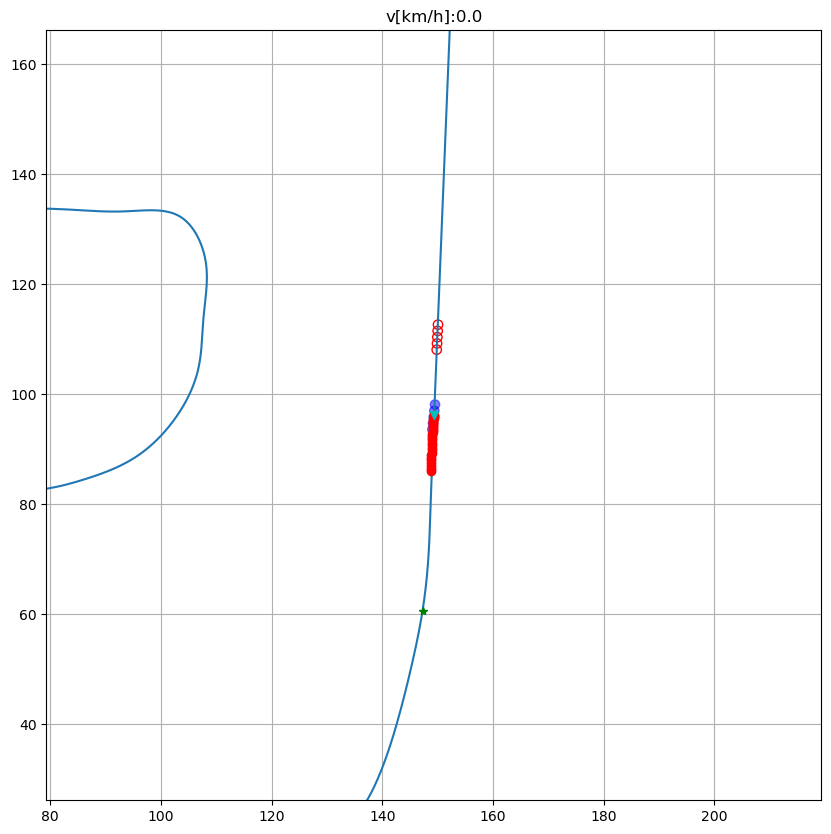

Finish


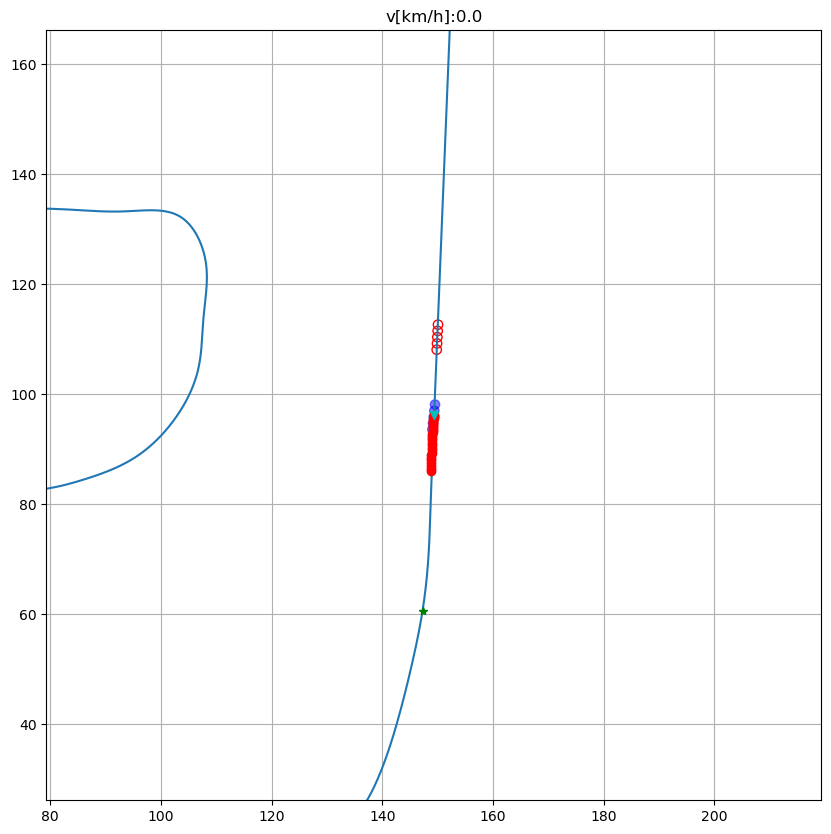

In [12]:
# Start the simulation
for i in range(SIM_LOOP):
    
    print('iteration: ' + str(i))
    # Stop exist
    lead_vehicle_exist = False
    # Regenerate the Obstacle List
    ob = np.vstack([obstacle1.vehicle_obs_arr, obstacle2.vehicle_obs_arr])

    path = Planner.plan(csp, ob, lead_exist=lead_vehicle_exist, lead_d=diff_vehicles, lead_v=lead_v)
    step_d = 5
    print('x: ' + str(path.x[0]) + ', y:' + str(path.y[0]) + ', yaw' + str(path.yaw[0]))
    if 120 < i < 200:
        lead_y = wy_r[step_d * i]
        lead_x = wx_r[step_d * i]
        dy = wy_r[step_d * (i + 1)] - wy_r[step_d * i]
        dx = wx_r[step_d * (i + 1)] - wx_r[step_d * i]
        lead_v = np.sqrt(dx**2 + dy**2) / 0.5
        yaw_lead = np.arctan2(dy, dx)
        print(lead_x)
        print(lead_y)
        obstacle1.change_position(lead_x, lead_y, yaw_lead)

        # Convert the coordinate distance into frenet distance
        lead_s, lead_d = calculate_frenet_coordinates(wx_r, wy_r, lead_x, lead_y)

        # Change lead_vehicle_exist to True
        lead_vehicle_exist = True
        diff_vehicles = lead_s - path.s[1]
        
    plt.rcParams['figure.figsize'] = [10, 10]
    try:
        if show_animation:
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect(
                'key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(tx, ty)
            plt.plot(traffic_light_x, traffic_light_y, 'g*')
            # Adding a circle around (tx, ty)
            Planner.vehicle.plot_vehicle(plt)
            for point in ob:
                circle = plt.Circle((point[0], point[1]), radius=point[2], color='r', fill=False)
                plt.gca().add_patch(circle)

            plt.plot(path.x[1:], path.y[1:], "-or")
            plt.plot(path.x[1], path.y[1], "vc")
            plt.xlim(path.x[1] - area, path.x[1] + area)
            plt.ylim(path.y[1] - area, path.y[1] + area)
            plt.title("v[km/h]:" + str(c_speed * 3.6)[0:4])
            plt.grid(True)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            #plt.pause(0.2)
    except Exception as e:
        print("Planning Done Before Iteration", e)
        break

print("Finish")
if show_animation:
    plt.grid(True)
    #plt.pause(0.2)
    plt.show()